In [1]:
%cd ../../

/mnt/sda/otani/Experiments/eval-detection


In [29]:
from mmdet.core.visualization import imshow_det_bboxes
import numpy as np
from src.extensions.metrics.ot_cost import get_ot_cost, get_cmap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
%matplotlib inline

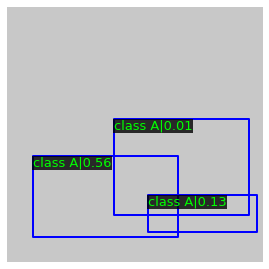

In [3]:
def get_random_bboxes(n, width, height, w_score=True):
    rng = np.random.default_rng()
    bboxes = []
    for _ in range(n):
        x = rng.integers(int(width*0.1), int(width * 0.9))
        y = rng.integers(int(height*0.1), int(height * 0.9))
        dx = rng.integers(int(width*0.1), width - x)
        dy = rng.integers(int(height*0.1), height - y)
        bboxes.append([x, y, x+dx, y+dy])
    if w_score:
        score = np.sort(rng.random(n))[::-1]
        return np.hstack([np.asarray(bboxes), score[:, None]])
    else:
        return np.asarray(bboxes)

im = np.ones((255, 255, 3), dtype=np.uint8)
im *= 200
h, w, _ = im.shape
bboxes=get_random_bboxes(3, w, h)
labels=np.asarray(np.zeros((3), dtype=np.uint8))
o_img = imshow_det_bboxes(im, bboxes, labels, class_names=["class A"], bbox_color="blue")

(-0.5, 1499.5, 254.5, -0.5)

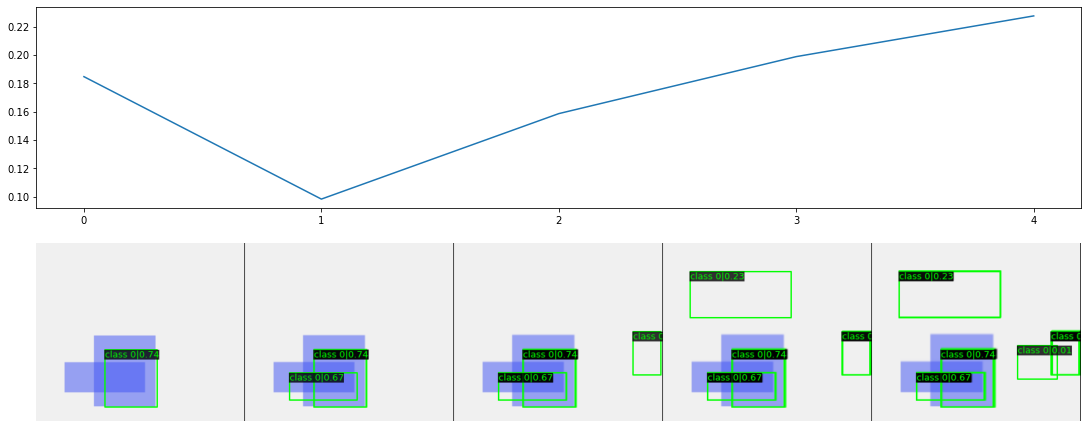

In [4]:
img = np.ones((255, 300, 3), dtype=np.uint8) * 240
h, w = img.shape[:2]
gt_bboxes = get_random_bboxes(2, w, h)
gt_bboxes[:, -1] = 1
gt_bboxes = gt_bboxes
rng = np.random.default_rng()
bboxes = gt_bboxes[:,:4] + rng.integers(0, min(h, w)*0.1, (len(gt_bboxes), 4))
red_bboxes = get_random_bboxes(3, w, h, w_score=False)
bboxes = np.vstack([bboxes, red_bboxes])
score = np.sort(rng.random(len(bboxes)))[::-1]
bboxes = np.hstack([np.asarray(bboxes), score[:, None]])
# bboxes = rng.permutation(bboxes)

gt_color = np.asarray([61, 80, 245], dtype=np.uint8)
for x1, y1, x2, y2, _ in gt_bboxes:
    x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
    img[y1:y2, x1:x2, :] = 0.5 * img[y1:y2, x1:x2, :] + 0.5 * gt_color

cmap_f = lambda x, y: get_cmap(x, y, alpha=0.5, beta=0.5, use_dummy=True)
imgs = []
otcs = []
for i in range(len(bboxes)):
    labels = np.zeros((i+1,), dtype=np.int64)
    img = imshow_det_bboxes(img, bboxes[:i+1], labels = labels, bbox_color="green", show=False)
    img[:, -1, :] = 0
    imgs.append(img)
    otc = get_ot_cost([gt_bboxes], [bboxes[:i+1]], cmap_f)
    otcs.append(otc)

fig = plt.figure(constrained_layout=True, figsize=(15, 6))
spec = gridspec.GridSpec(ncols=5, nrows=4, figure=fig)
cost_axes = []
cost_ax = fig.add_subplot(spec[:2, :])   
cost_ax.plot(np.arange(len(otcs)), otcs)
cost_ax.set_xticks(range(len(imgs)))
cost_ax.set_xticklabels(range(len(imgs)))
    # cost_ax.set_ylim(0.1, 0.6)
    # cost_axes.append(cost_ax)

im_ax = fig.add_subplot(spec[2:, :])
im_ax.imshow(np.hstack(imgs))
im_ax.axis("off")

[222 239   0  17  34]


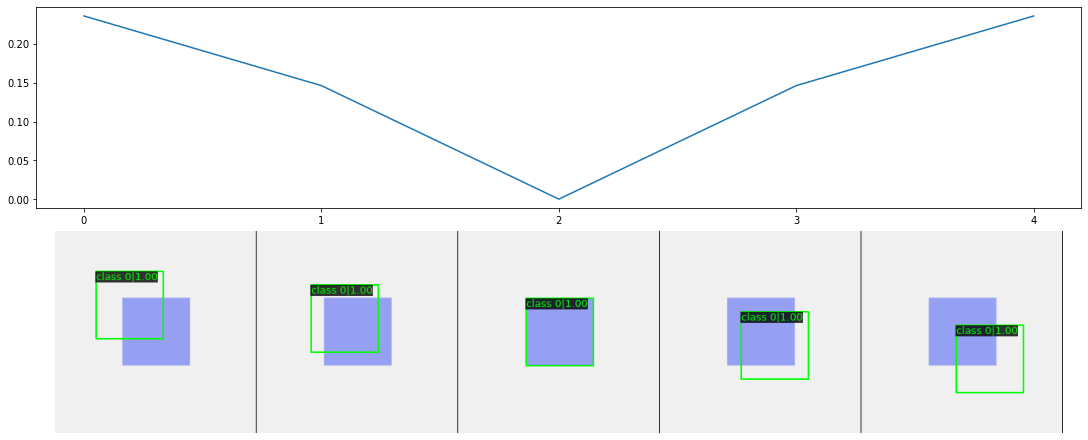

In [6]:
def toy_example():
    width, height = 255, 255
    x1, y1, x2, y2 = width/3, height/3, width*2/3, height*2/3
    gt_bboxes = np.asarray([[x1, y1, x2, y2, 1]]).astype(np.uint8)
    d = (x2-x1)/5
    offsets = np.linspace(-2*d, 2*d, 5).astype(np.uint8)
    print(offsets)
    bboxes = []
    for o in offsets:
        b = np.ones_like(gt_bboxes)
        b[0, :4] = gt_bboxes[0, :4]+o
        bboxes.append(b)
    
    bboxes = np.vstack(bboxes)

    img = np.ones((width, height, 3), dtype=np.uint8) * 240
    gt_color = np.asarray([61, 80, 245], dtype=np.uint8)
    for x1, y1, x2, y2, _ in gt_bboxes:
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        img[y1:y2, x1:x2, :] = 0.5 * img[y1:y2, x1:x2, :] + 0.5 * gt_color

    cmap_f = lambda x, y: get_cmap(x, y, alpha=0.5, beta=0.5, use_dummy=True)
    imgs = []
    otcs = []
    for i in range(len(bboxes)):
        # labels = np.zeros((i+1,), dtype=np.int64)
        _img = imshow_det_bboxes(img, bboxes[i:i+1], labels = np.asarray([0]), bbox_color="green", show=False)
        _img[:, -1, :] = 0
        imgs.append(_img)
        otc = get_ot_cost([gt_bboxes], [bboxes[i:i+1]], cmap_f)
        otcs.append(otc)

    fig = plt.figure(constrained_layout=True, figsize=(15, 6))
    spec = gridspec.GridSpec(ncols=5, nrows=4, figure=fig)

    cost_ax = fig.add_subplot(spec[:2, :])   
    cost_ax.plot(np.arange(len(otcs)), otcs)
    cost_ax.set_xticks(range(len(imgs)))
    cost_ax.set_xticklabels(range(len(imgs)))

    im_ax = fig.add_subplot(spec[2:, :])
    im_ax.imshow(np.hstack(imgs))
    im_ax.axis("off")
    
toy_example()

[[ 10.  20. 111. 133.   1.]
 [120. 120. 247. 241.   1.]]
[array([[ 11.        ,   6.        ,  95.        , 141.        ,
          0.25336513],
       [108.        , 111.        , 249.        , 225.        ,
          0.28999072]], dtype=float32), array([[6.0000000e+01, 2.0000000e+02, 2.0000000e+02, 2.4000000e+02,
        2.1734892e-01]], dtype=float32)]


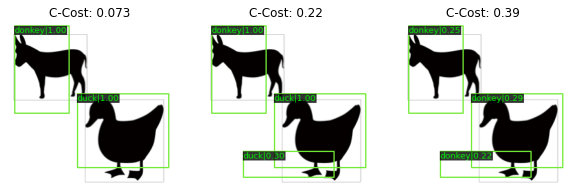

In [84]:
def get_image(bboxes):
    width, height = 255, 255
    img = np.ones((width, height, 3), dtype=np.uint8) * 255

    donky = Image.open("data/sample_img/k0217_4.jpg")
    donky = donky.resize((np.array(donky.size)/4).astype(int))
    donky = np.asarray(donky)
    donky_h, donky_w = donky.shape[:2]
    duck = Image.open("data/sample_img/k0228_1.jpg")
    duck = duck.resize((np.array(duck.size)/4).astype(int))
    duck = np.asarray(duck)
    duck_h, duck_w = duck.shape[:2]

    bboxes = []
    offset_x, offset_y = 10, 20
    bboxes.append([offset_x, offset_y, offset_x+donky_h, offset_y+donky_w, 1.0])
    img[offset_y:offset_y+donky_h, offset_x:offset_x+donky_w, :] = donky
    
    img[offset_y, offset_x:offset_x+donky_w] = [200, 200, 200]
    img[offset_y+donky_h, offset_x:offset_x+donky_w] = [200, 200, 200]
    img[offset_y:offset_y+donky_h, offset_x] = [200, 200, 200]
    img[offset_y:offset_y+donky_h, offset_x+donky_w] = [200, 200, 200]

    offset_x, offset_y = 120, 120
    bboxes.append([offset_x, offset_y, offset_x+duck_h, offset_y+duck_w, 1.0])
    img[offset_y:offset_y+duck_h, offset_x:offset_x+duck_w, :] = duck

    img[offset_y, offset_x:offset_x+duck_w] = [200, 200, 200]
    img[offset_y+duck_h, offset_x:offset_x+duck_w] = [200, 200, 200]
    img[offset_y:offset_y+duck_h, offset_x] = [200, 200, 200]
    img[offset_y:offset_y+duck_h, offset_x+duck_w] = [200, 200, 200]

    return img, np.asarray(bboxes).astype(np.float32), np.asarray([0, 1])

def localization_error_exp(bboxes, label, img, ref_bboxes):
    rng = np.random.default_rng()
    localization_error_bbox = bboxes.copy()
    localization_error_bbox[:, :4] += rng.integers(low=0, high=40, size=(2, 4)) - 20
    img_ = imshow_det_bboxes(img, localization_error_bbox, labels=label, class_names=["donkey", "duck"], bbox_color=(113, 235, 52), show=False)

    cmap_f = lambda x, y: get_cmap(x, y, alpha=0.5, beta=0.5, use_dummy=True)
    refs = [b[None, :] for b in ref_bboxes]
    preds = [b[None, :] for b in localization_error_bbox]
    cost = get_ot_cost(refs, preds, cmap_f)
    return localization_error_bbox, cost, img_

def classification_error_exp(bboxes, img, ref_bboxes):
    rng = np.random.default_rng()
    classification_error_bbox = bboxes.copy()
    classification_error_bbox[:, -1] = rng.random((len(classification_error_bbox),))
    label = np.random.randint(0, 2, len(classification_error_bbox))
    
    img_ = imshow_det_bboxes(img, classification_error_bbox, labels=label, class_names=["donkey", "duck"], bbox_color=(113, 235, 52), show=False)

    cmap_f = lambda x, y: get_cmap(x, y, alpha=0.5, beta=0.5, use_dummy=True)

    preds = [classification_error_bbox[:2], classification_error_bbox[-1][None, :]]
    refs = [b[None, :] for b in ref_bboxes]

    print(ref_bboxes)
    print(preds)
    cost = get_ot_cost(refs, preds, cmap_f)
    return classification_error_bbox, cost, img_

def adding_extra_detection_error_exp(bboxes, label, img, ref_bboxes):
    extr_bbox = np.asarray([[60, 200, 200, 240, 0.3]]).astype(np.float32)
    extr_label = np.asarray([1])
    extr_bbox = np.vstack([bboxes, extr_bbox])
    extr_label = np.hstack([label, extr_label])

    img_ = imshow_det_bboxes(img, extr_bbox, labels=extr_label, class_names=["donkey", "duck"], bbox_color=(113, 235, 52), show=False)

    cmap_f = lambda x, y: get_cmap(x, y, alpha=0.5, beta=0.5, use_dummy=True)
    refs = [b[None, :] for b in ref_bboxes]
    preds = [b[None, :] for b in extr_bbox]
    cost = get_ot_cost(refs, preds, cmap_f)
    return extr_bbox, extr_label, cost, img_


# bboxes, label = get_init_bbox()
init_img, bboxes, label = get_image(bboxes)
ref_bboxes = bboxes.copy()
imgs = []
costs = []

ptb_bboxes, cost, res_img = localization_error_exp(bboxes, label, init_img, ref_bboxes)
imgs.append(res_img)
costs.append(cost)

ptb_bboxes, ptb_label, cost, res_img = adding_extra_detection_error_exp(ptb_bboxes, label, init_img, ref_bboxes)
imgs.append(res_img)
costs.append(cost)

ptb_bboxes, cost, res_img = classification_error_exp(ptb_bboxes, init_img, ref_bboxes)
imgs.append(res_img)
costs.append(cost)



f, axes = plt.subplots(1, 3, figsize=(10, 30))
for im, cost, ax, i in zip(imgs, costs, axes, range(3)):
    plt.imsave(f"tmp/img_{i}.png", im)
    ax.imshow(im)
    ax.axis("off")
    ax.set_title(f"C-Cost: {cost:.2}")


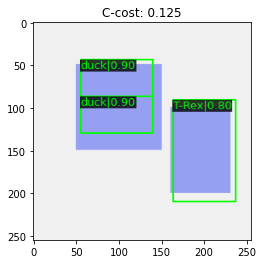

In [60]:
def split_bbox(bbox):
    x1, y1, x2, y2, s = bbox
    return np.asarray([[x1, y1, x2, (y2+y1)//2, s], [x1, (y2+y1)//2, x2, y2, s]])
    
def split_error_exp():
    img = get_image()
    bboxes, label = get_init_bbox()

    gt_color = np.asarray([61, 80, 245], dtype=np.uint8)
    for x1, y1, x2, y2, _ in bboxes:
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        img[y1:y2, x1:x2, :] = 0.5 * img[y1:y2, x1:x2, :] + 0.5 * gt_color

    splitted_bboxes = bboxes.copy()
    splitted_bboxes[:, :4] += rng.integers(low=0, high=40, size=(2, 4)) - 20
    splitted_bboxes = np.vstack([split_bbox(splitted_bboxes[0]), splitted_bboxes[1]])
    label = np.hstack((label[0], label))
    
    img_ = imshow_det_bboxes(img, splitted_bboxes, labels=label, class_names=["duck", "T-Rex"], bbox_color="green", show=False)

    cmap_f = lambda x, y: get_cmap(x, y, alpha=0.5, use_dummy=True)
    splitted_bboxes = [splitted_bboxes[:2], splitted_bboxes[-1][None, :]]
    cost, log = get_ot_cost([b[None, :] for b in bboxes], splitted_bboxes, cmap_f, return_matrix=True)
    plt.imshow(img_)
    plt.title(f"C-cost: {cost:.3}")
    return log

log = split_error_exp()

In [63]:
np.random.randint(0, 2, 3)

array([1, 0, 1])

In [40]:
donky[60, 80]

array([  4,   0,   0, 255], dtype=uint8)